In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Clustering
- 잠재 변수는 데이터의 가장 압축된 표현이라고 할 수 있다.
- 잠재변수에는 데이터를 효과적으로 복원할 수 있도록 중요한 정보만 포함이 된다.

- 지도 학습과는 달리 비지도 학습은 입력에 대한 정답 출력이 존재하지 않기 때문에 우리는 잼재 변수를 이용해서 데이터를 여러개의 군집으로 나누는 클러스터링을 알고리즘을 이용해 진행할 수 있다.

1. K-평균 클러스터링
    - 주어진 입력 중에서 K개의 클러스터 중심으로 임의로 정한 다음에 각 데이터와 K개의 중심과의 거리를 비교해서 가장 가까운 클러스터로 배정하고, K개의 중심의 위치를 해당 클러스터로 옮긴 다음에 이를 반복한다.
    - 어차피 클러스터링은 **잠재 변수**를 이용해서 진행하는 학습이기 때문에 먼저 잠재 변수를 추출하는 것에 초점을 두어야 한다.

In [4]:
(train_x, _), (test_x, _) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

In [6]:
train_x = (train_x/255).astype('float32')
test_x = (test_x/255).astype('float32')
train_x, test_x = train_x.reshape(-1,28,28,1), test_x.reshape(-1,28,28,1)
model = Sequential()
model.add(Conv2D(filters = 32, strides = 2, kernel_size = (2,2), activation = LeakyReLU(0.2), input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, strides = 2, kernel_size = (2,2), activation = LeakyReLU(0.2)))
model.add(Flatten())
model.add(Dense(64, activation = LeakyReLU(0.2)))
model.add(Dense(7*7*64, activation = LeakyReLU(0.2)))
model.add(Reshape((7,7,64)))
model.add(Conv2DTranspose(filters = 32, strides = 2, kernel_size = (2,2), padding = 'same', activation = LeakyReLU(0.2)))
model.add(Conv2DTranspose(filters = 1, kernel_size = (2,2), strides = 2, padding = 'same', activation = 'sigmoid'))

In [7]:
model.summary()
model.compile(loss = 'mse', optimizer = 'adam', metrics= ['accuracy'])
model.fit(train_x, train_x, epochs = 20, batch_size = 256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                200768    
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        8

In [8]:
model.evaluate(test_x, test_x, verbose = 0)

[0.006185891550779343, 0.5073082]

**잠재 변수 추출 모뎅 정의 및 실행**

In [9]:
char_model = tf.keras.Model(inputs = model.input, outputs = model.layers[3].output)
char = char_model.predict(train_x)
print(char.shape, char[0])

(60000, 64) [ 7.09508371e+00  1.67094021e+01  9.03003788e+00  2.99637794e+00
  4.09060431e+00  9.51343250e+00  6.42041874e+00  2.05463715e+01
  4.62920427e+00  2.95334196e+00  1.02092705e+01  7.17794943e+00
  4.68928337e+00  1.22789669e+01  3.01817584e+00  2.99534583e+00
  7.25868082e+00  2.23290563e+00  7.55537319e+00  5.33559847e+00
  6.64988232e+00 -3.47027016e+00  6.03303051e+00  7.57433462e+00
  1.42934179e+01  7.35666513e+00  8.53885460e+00  5.64685774e+00
 -7.29185724e+00  7.41008949e+00  2.94874883e+00  7.32841301e+00
  5.26992273e+00  4.50083208e+00  8.12386227e+00  1.34135952e+01
  5.93516159e+00  1.58049202e+01  9.68978214e+00  4.60757589e+00
  1.05532484e+01  2.06503320e+00 -2.89611821e-03  5.48011684e+00
  3.43060756e+00  2.67783308e+00  1.69940948e+01  9.53975201e+00
  5.23064899e+00  1.32684908e+01  1.25486698e+01  3.39927077e+00
  2.13827848e+00  8.41307831e+00  9.00912285e+00  3.78221560e+00
  3.09724689e+00  9.54597282e+00  9.10697079e+00  6.06576109e+00
  1.65258942e

- 이제 sklearn의 라이브러리를 사용해서 k-clustering을 하는 것이 가능하다.
- KMeans에 들어가는 파라미터에 대해서 설명을 해보면
    1. n_clusters: 
        - 총 군집의 개수(보통 클래스의 개수로 정한다.)
    2. n_init:
        - 알고리즘의 실행 횟수
    3. random_state:
        - 알고리즘의 계산 결과를 동일하게 가져가기 위해서 지정하는 랜덤 초기화 숫자
        
- KMeans에 잠재 변수를 fit해준 이후에 label값을 출력하면 각 데이터가 어떤 label에 속하는 지 알 수 있다.

**그러나 Autoencoding을 공부하다가 클러스터링이라는 개념이 나온 것이었기 때문에 왜 이 개념이 등장하는지 궁금해서 KMeans의 원리를 찾아 보았다.**

1. 구하고자 하는 데이터중에 임의로 'n_clusters'의 개수만큼 수를 선택해 이 수들을 cluster의 sentroid값으로 설정한다.
2. 이후에도 반복적으로 진행을 해서 sentroid의 값을 갱신시킨다.
3. 더이산 sentroid의 값에 변화가 없을것 같을 때 멈춘다.

- 생각보다 너무 단순한 알고리즘을 이용해서 작동 했는데, 우리가 각 샘플 데이터마다 라벨링이 되어 있는 상황이라면 학습을 시키는 것에 중요한 것이 사실상 데이터 처리와 모델링 밖에 없겠지만, 만약에 **라벨링이 안된 상태라면 정확한 군집화가 중요**할 것이라는 생각이 들었다

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, n_init = 10, random_state = 42)
kmeans.fit(char)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [11]:
kmeans.labels_

array([3, 1, 2, ..., 7, 2, 0])

In [12]:
kmeans.cluster_centers_.shape

(10, 64)

In [13]:
len(kmeans.cluster_centers_[0])

64

- 위의 정보는 각 cluster의 sentroid 값이 저장된 것이지만 위에서 잠재 변수를 구해주기 위해서 이용한 Dense layer이 64차원이었기 때문에 이 정보도 각 데이터당 64차원이라서 무엇을 의미하는지 알기 힘들다.
    - **하지만 보니까 각 이미지의 픽셀값을 의미있는 부분집합으로 나눈것 같다**
- 따라서 이 정보들을 시각화해 보아야 한다.

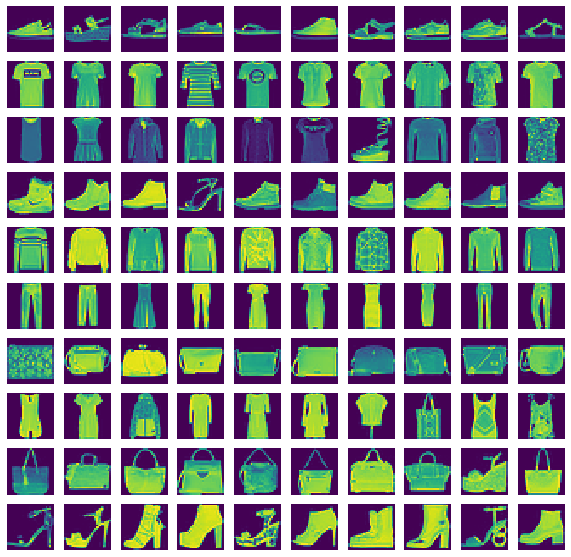

In [16]:
#현재 내가 시각화를 출력하고 싶은 구역의 크기 설정
plt.figure(figsize = (10,10))

for i in range(10):
    #군집 결과상으로 라벨이 i인 자료
    images = train_x[kmeans.labels_ == i]
    for c in range(10):
        plt.subplot(10,10,i*10+c+1)
        plt.imshow(images[c].reshape(28,28))
        plt.axis('off')
plt.show()
    

- 살짝 차이가 있기도 하지만 전반적으로 군집화가 잘 된듯 보인다.
- 잠재 변수의 차원을 늘리거나 알고리즘 반복 횟수인 n_init의 값을 늘려서 분류를 더 잘 되게 할 수도 있으며, cluster의 값을 늘려서 더욱 세분화 할 수 있다.  

#### 이제는 **t-SNE**를 이용해서 잠재 변수를 군집화 해보자.
    - 이는 위의 kmeans.cluster_centers_ 와 같이 고차원의 데이터를 저차원으로 시각화 하기 위한 데이터로 변환한다.  
    
- t-SNE의 작동 원리를 살펴 보자면 
    1. 각 데이터의 유사도를 정의하고 원래 고차원의 공간에서의 유사도와 저차원에서의 유사도가 비슷하도록 학습을 시킨다.
    2. 유사도는 확률로 표현이 되기 때문에 **데이터 하나를 중심으로 다른 데이터를 거리에 대한 t-분포의 확률로 치환**시킨 것과 같다.
    3. 고차원과 저차원에서 확률 값을 각각 구한 뒤에 저차원의 확률값이 고차원에 가까워지도록 학습하는 것이다.

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, learning_rate = 100, perplexity = 35, random_state = 0)
#고차원의 잠재 변수를 이용(정보가 너무 많으면 시간이 너무 오래 걸려 일부만 사용)
tsne_vector = tsne.fit_transform(char[:5000])

In [32]:
len(tsne_vector)

5000

In [33]:
tsne_vector

array([[ -8.5679655 ,  57.394173  ],
       [-23.936083  ,  20.338676  ],
       [-25.601177  , -14.700657  ],
       ...,
       [ 18.279032  ,  44.009037  ],
       [ 53.84419   ,   0.72005427],
       [-44.881287  ,  -8.9478    ]], dtype=float32)

- tsne_vector을 출력한 값을 보면 각각의 데이터에 대해서 유사도를 각각 저차원에서 확률로서 구한 수치를 저장해 놓은 것으로 보인다.
- 위의 ```n_compontents```의 값에 2를 넣은것은 변환하고 싶은 저차원이 2차원의 공간이라는 의미이고, ```perplexity```는 한번에 고려할 주변 대상의 개수이며 학습률인 ```learning_rate```는 일반적으로 1이하의 수를 넣지만 이 경우에는 10과 100사이의 값을 넣는다.

In [34]:
train_y = _

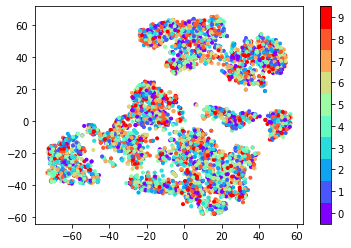

In [35]:
cmap = plt.get_cmap('rainbow', 10)
fig = plt.scatter(tsne_vector[:,0], tsne_vector[:,1], marker = '.', c = train_y[:5000], cmap = cmap)
cb = plt.colorbar(fig, ticks = range(10))
tick_locks = (np.arange(10)+0.5) * 0.9
cb.set_ticks(tick_locks)
cb.set_ticklabels(range(10))

In [25]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

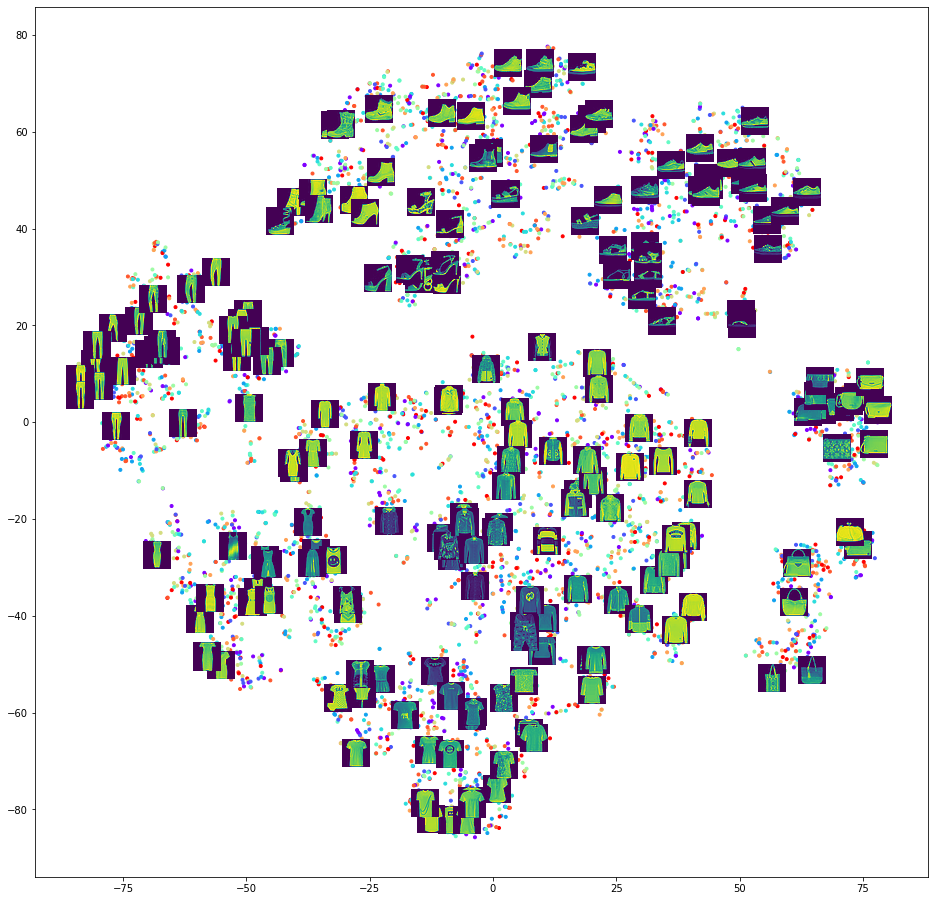

In [40]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

plt.figure(figsize = (16,16))

tsne = TSNE(n_components = 2, learning_rate = 100, perplexity = 15, random_state = 0)
tsne_vector = tsne.fit_transform(char[:5000])

ax = plt.subplot(1,1,1)
ax.scatter(tsne_vector[:,0], tsne_vector[:,1], marker = '.', c = train_y[:5000], cmap = 'rainbow')
for i in range(200):
    imagebox = OffsetImage(train_x[i].reshape(28,28))
    ab = AnnotationBbox(imagebox, (tsne_vector[i][0], tsne_vector[i][1]), frameon = False, pad = 0.0)
    ax.add_artist(ab)
    

#### 정리
- 데이터를 학습하고 훈련하는데 필수적인 labeling을 하는 방법중에 하나인 군집화, 즉 clustering의 두 대표적인 방법에 대해서 실습을 해 보았다.
- 클러스터링을 하기 위해서는 우선적으로 **정재 변수**를 구해야 하는데, 이 고차원의, 압축된 데이터에 대한 정보는 **오토인코더의 비지도 학습을 통해**구할 수 있다.
1. 일단 k-means-clustering을 하는 방법이 존재하는데, 이는 **군집의 중심과 데이터간의 거리를 계산**해서 군집화 하는 것이다. 
    - 따라서 압축된 데이터를 기준으로 차원수 그대로의 데이터를 생성한다.
2. 또 다른 방법은 t-SNE인데, 이는 **저차원, 고차원 공간에서의 유사도를 비슷하세**학습해서 군집화 하는 것이다.
    - 따라서 고차원의 데이터를 정해주는 차원대로 저차원으로 줄여서 표현이 가능하다는 장점이 존재한다.